**Emotion Detection in Twitter Data using NLP Techniques**


You have been given with a dataset of Twitter posts (tweets) that are labelled with specific emotions. Your objective is to develop a model that can accurately classify these tweets into different emotion categories such as joy, sadness, anger, fear, surprise etc.


Importing Libraries

In [88]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import html
import re
import unicodedata

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM,Embedding, LSTM,Bidirectional,SimpleRNN,Dropout, Dense
from tensorflow.keras.layers import BatchNormalization

**DATA LOADING DATASET**

In [89]:
#Reading the dataset
tweet_emotions=pd.read_csv("/content/tweet_emotions.csv",encoding="ISO-8859-1")


In [90]:
# Display the dataset
tweet_emotions

,tweet_id,sentiment,content
0,1956967341,empty,@tiffanylue i know i was listenin to bad habi...
1,1956967666,sadness,Layin n bed with a headache ughhhh...waitin o...
2,1956967696,sadness,Funeral ceremony...gloomy friday...
3,1956967789,enthusiasm,wants to hang out with friends SOON!
4,1956968416,neutral,@dannycastillo We want to trade with someone w...
...,...,...,...
39995,1753918954,neutral,@JohnLloydTaylor
39996,1753919001,love,Happy Mothers Day All my love
39997,1753919005,love,Happy Mother's Day to all the mommies out ther...
39998,1753919043,happiness,@niariley WASSUP BEAUTIFUL!!! FOLLOW ME!! PEE...


In [91]:
tweet_emotions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   tweet_id   40000 non-null  int64 
 1   sentiment  40000 non-null  object
 2   content    40000 non-null  object
dtypes: int64(1), object(2)
memory usage: 937.6+ KB


In [92]:
# Checking Missing values
tweet_emotions.isnull().sum()

,0
tweet_id,0
sentiment,0
content,0


In [93]:
tweet_emotions.columns

Index(['tweet_id', 'sentiment', 'content'], dtype='object')

**DATA CLEANING AND PREPROCESSING**

In [94]:
#The column 'emotion_in_tweet_is_directed_at' is unnecessary column.so drop it.
tweet_emotions = tweet_emotions.drop(columns='tweet_id')

In [95]:
tweet_emotions.columns

Index(['sentiment', 'content'], dtype='object')

In [96]:
#count the values in the column 'user sentiment'
tweet_emotions['sentiment'].value_counts()

,count
sentiment,
neutral,8638
worry,8459
happiness,5209
sadness,5165
love,3842
surprise,2187
fun,1776
relief,1526
hate,1323


In [97]:
#checking out the anger emotion from dataset
tweet_emotions[tweet_emotions['sentiment']=='anger'].head(10)

,sentiment,content
494,anger,fuckin'm transtelecom
527,anger,Working But it's Fridaaaayyyyy
612,anger,Packing I don't like it..
1377,anger,I tried to dye my hair and all i got was a blo...
1384,anger,&quot;locked up abroad&quot; makes bein half b...
1498,anger,@LouGagliardi damned hordies
1993,anger,"@bcollinstattoo yes, boo for soar throats and ..."
2135,anger,My stomach is all EXPLODE from the wendys why...
2619,anger,"@rmilana Hey, Wahts happening in #coffeclub..?..."
2629,anger,Did a historical Jesus ever exist? Im finding ...


In [98]:
#checking out the boredom emotion from dataset
tweet_emotions[tweet_emotions['sentiment']=='boredom'].head(10)

,sentiment,content
112,boredom,i'm so tired
316,boredom,Waiting in line @ tryst
345,boredom,why did i agree to work a double shift
495,boredom,"is really, really bored... I guess I will go t..."
583,boredom,So deep its priecing my soul
957,boredom,"THIS TWITTER SHIT BORES ME, NOW I C Y I HAVEN'..."
1074,boredom,Not actually managed to purchase anything from...
1104,boredom,Tweeting from the tarmac at Cork Airport. Delayed
1159,boredom,Feeling nauseous and can't sleep.
1242,boredom,Friday tubes at work are slow..


In [99]:
#checking out the enthusiasm emotion from dataset
tweet_emotions[tweet_emotions['sentiment']=='enthusiasm'].head(10)

,sentiment,content
3,enthusiasm,wants to hang out with friends SOON!
56,enthusiasm,"bed...sorta. today was good, sara has strep th..."
422,enthusiasm,I want another tatt
424,enthusiasm,"So, I need to make a lot of money tomorrow"
444,enthusiasm,@lilxamyx08 i know ridiculous! we never got to...
544,enthusiasm,one week till exam block
562,enthusiasm,@calvinharris stop talkin about food haha fill...
593,enthusiasm,Q: what studio created 'Open Season'? should g...
739,enthusiasm,Counting the minutes when my dad's g-friend is...
742,enthusiasm,@leopardqueen @seekinspiration Have fun! I mis...


In [100]:
#checking out the empty emotion from dataset
tweet_emotions[tweet_emotions['sentiment']=='empty'].head(10)

,sentiment,content
0,empty,@tiffanylue i know i was listenin to bad habi...
44,empty,@creyes middle school and elem. High schools w...
52,empty,@djmicdamn hey yu lil fucker i textd yu
141,empty,@softtouchme just answered you- never learned ...
180,empty,Have a headache I'm going to bed. Goodnight!
203,empty,@DymeDiva23 Nite. Now I'm up n bored as oppose...
238,empty,"@TheTombert i was watching Harpers Island, lol..."
244,empty,@tarng Trudy's off Burnet...the one up north t...
272,empty,@msz_rockstar umm how bout em?..aint get 2 see...
339,empty,I need to be sleeping.. But i'm not even tired..


In [101]:
#checking out the hate emotion from dataset
tweet_emotions[tweet_emotions['sentiment']=='relief'].head(10)

,sentiment,content
147,relief,I'm at work
215,relief,"is done painting all the bedroom furniture, I ..."
312,relief,Scary lightning and thunder I'm glad it's ove...
380,relief,is home. safely... but hungry
406,relief,just finished 8 hours of Texas Life Insurance ...
419,relief,"@AnthonyLucas @iainfunnell Yeah, physically mo..."
524,relief,Headin home...Refreshed my mind and soul justa...
623,relief,@charlieboy808 thanks for the rt and sorry abo...
631,relief,@kaseypoteet LOL yeah yeah you big perv ;) Was...
679,relief,@nawid nope het is LOST&amp;found he ;-)


In [102]:
#checking out the relief emotion from dataset
tweet_emotions[tweet_emotions['sentiment']=='relief'].head(10)

,sentiment,content
147,relief,I'm at work
215,relief,"is done painting all the bedroom furniture, I ..."
312,relief,Scary lightning and thunder I'm glad it's ove...
380,relief,is home. safely... but hungry
406,relief,just finished 8 hours of Texas Life Insurance ...
419,relief,"@AnthonyLucas @iainfunnell Yeah, physically mo..."
524,relief,Headin home...Refreshed my mind and soul justa...
623,relief,@charlieboy808 thanks for the rt and sorry abo...
631,relief,@kaseypoteet LOL yeah yeah you big perv ;) Was...
679,relief,@nawid nope het is LOST&amp;found he ;-)


In [103]:
#checking out the fun emotion from dataset
tweet_emotions[tweet_emotions['sentiment']=='fun'].head(10)

,sentiment,content
21,fun,"Wondering why I'm awake at 7am,writing a new s..."
41,fun,@DavidArchie &lt;3 your gonna be the first tw...
148,fun,RIP leonardo. You were a great mini fiddler crab
165,fun,@IdleThumbs Up is out? I didn't get the memo ...
179,fun,@relly1 OMG Ur alive!!! LOL 2day has gone so...
182,fun,@JessiJaeJoplin did you get them from californ...
198,fun,(@wendyisastar) @melluffsyew Umm yeah. That's ...
286,fun,@OooChelcyooO That's awesome! We have that thi...
471,fun,i should be finished.... but i'm not. color d...
658,fun,@plantweb Lettuce &amp; spinach does best in ...


In [104]:
#checking out the surprise emotion from dataset
tweet_emotions[tweet_emotions['sentiment']=='surprise'].head(10)

,sentiment,content
14,surprise,Got the news
164,surprise,"2 days of this month left, and I only have 400..."
189,surprise,@Bern_morley where are you? In Bris? I can't h...
190,surprise,bec vs fat food --- winner = fat food but n...
192,surprise,I had a dream about a pretty pretty beach and ...
194,surprise,when da heck will the garage man get here I as...
223,surprise,Why am I completing facebook quizzes at this t...
255,surprise,"@Gurlstrange EpiCentre Wheelock Place, 250 uni..."
259,surprise,@FoxxFiles aw u can't let me in on the secret!
260,surprise,@freshypanda Im sorry I don't think I stick o...


In [105]:
#checking out the love emotion from dataset
tweet_emotions[tweet_emotions['sentiment']=='love'].head(10)

,sentiment,content
16,love,@annarosekerr agreed
94,love,@RobertF3 correct! I ADORE him. I just plucked...
122,love,@freepbx sounds good. Appreciate the suggestio...
131,love,Pats in philly at 2 am. I love it. Mmm cheeses...
151,love,@NisforNeemah thanks neemah. I'm gonna be sooo...
210,love,@bobbyedner i missed the game
397,love,@neyoofficial: love the song &quot;together&qu...
408,love,I want to go to Peru this summer ahhhhhhh! Hop...
438,love,Pug just woke me from an incredible sleep!
439,love,@ddlovato i can`t wait to hear your new album....


In [106]:
#checking out the sadness emotion from dataset
tweet_emotions[tweet_emotions['sentiment']=='sadness'].head(10)

,sentiment,content
1,sadness,Layin n bed with a headache ughhhh...waitin o...
2,sadness,Funeral ceremony...gloomy friday...
6,sadness,"I should be sleep, but im not! thinking about ..."
8,sadness,@charviray Charlene my love. I miss you
9,sadness,@kelcouch I'm sorry at least it's Friday?
12,sadness,Ugh! I have to beat this stupid song to get to...
13,sadness,@BrodyJenner if u watch the hills in london u ...
15,sadness,The storm is here and the electricity is gone
17,sadness,So sleepy again and it's not even that late. I...
19,sadness,How are YOU convinced that I have always wante...


In [107]:
#checking out the neutral emotion from dataset

tweet_emotions[tweet_emotions['sentiment']=='neutral'].head(10)

,sentiment,content
4,neutral,@dannycastillo We want to trade with someone w...
10,neutral,cant fall asleep
22,neutral,No Topic Maps talks at the Balisage Markup Con...
31,neutral,@cynthia_123 i cant sleep
32,neutral,I missed the bl***y bus!!!!!!!!
33,neutral,feels strong contractions but wants to go out....
34,neutral,SoCal! stoked. or maybe not.. tomorrow
35,neutral,Screw you @davidbrussee! I only have 3 weeks...
38,neutral,has work this afternoon
39,neutral,@GABBYiSACTiVE Aw you would not unfollow me wo...


In [108]:
#checking out the happiness emotion from dataset

tweet_emotions[tweet_emotions['sentiment']=='happiness'].head(10)

,sentiment,content
40,happiness,mmm much better day... so far! it's still quit...
69,happiness,So great to see Oin &amp; Cynthia. So happy. ...
77,happiness,"@havingmysay dude, that is my favorite sandwi..."
126,happiness,Need to pack for CALI CALI! Cannot waittt! Thi...
233,happiness,took a math test today. The day before the tes...
234,happiness,"omg, the concert was awesome, madrigals gave m..."
246,happiness,I Can`t do 30 minutes of Treadmill but done 3...
250,happiness,Chillin with the roomies. Can't wait for the z...
293,happiness,@vinylvickxen i kno i doooo!!!!!!!!!! yall par...
308,happiness,I spilled my beer all over my leg. Wasted half...


In [109]:
#checking out the worry emotion from dataset

tweet_emotions[tweet_emotions['sentiment']=='worry'].head(10)

,sentiment,content
5,worry,Re-pinging @ghostridah14: why didn't you go to...
7,worry,Hmmm. http://www.djhero.com/ is down
11,worry,Choked on her retainers
18,worry,@PerezHilton lady gaga tweeted about not being...
20,worry,@raaaaaaek oh too bad! I hope it gets better. ...
23,worry,I ate Something I don't know what it is... Why...
25,worry,On my way home n having 2 deal w underage girl...
27,worry,Damm servers still down i need to hit 80 befo...
29,worry,I HATE CANCER. I HATE IT I HATE IT I HATE IT.
37,worry,I need skott right now


/tmp/ipython-input-3976483271.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=tweet_emotions, x='sentiment', palette='Set3')


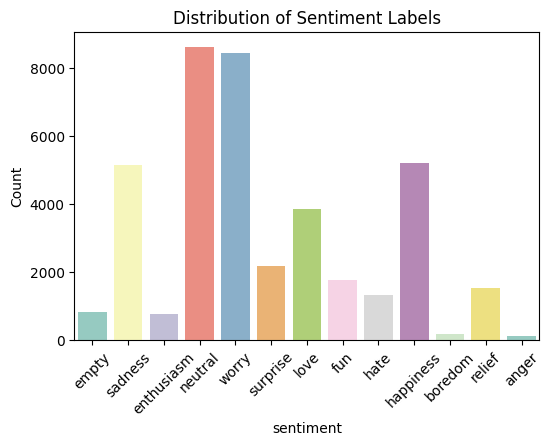

In [110]:
#Count plot for the column 'sentiment'

plt.figure(figsize=(6,4))
sns.countplot(data=tweet_emotions, x='sentiment', palette='Set3')

plt.title('Distribution of Sentiment Labels')
plt.xlabel('sentiment')
plt.ylabel('Count')

plt.xticks(rotation=45)
plt.show()

**TEXT PREPROCESSING**

In [111]:
# Download stopwords
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [112]:
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [113]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()


In [114]:
def preprocess_tweet(text):
    text = str(text).lower() # Lowercase
    text = re.sub(r'@\w+', '', text) # Remove mentions
    text = html.unescape(text)  # Decode HTML entities
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8') # Remove non-ASCII

    words = text.split() # Tokenize manually by splitting on spaces
    # Remove URLs and mentions/hashtags (check if word starts with  #, or contains 'http','www','{','}')
    words = [word for word in words if not (
        word.startswith('#') or 'http' in word or 'www' in word or
        'link' in word or '{' in word or '}' in word)]

    # Remove punctuation and numbers
    clean = []
    for word in words:
        word_alpha = ''.join(char for char in word if char.isalpha()) #keep only alpha numeric characters
        if word_alpha and word_alpha not in stop_words:
            clean.append(lemmatizer.lemmatize(word_alpha))
    # Join words back into a string
    return ' '.join(clean)

In [115]:
sample ="Hmmm.http://www.djhero.com/ is down"
print(preprocess_tweet(sample))

**Apply Preprocessing**

In [116]:
tweet_emotions['preprocess_content'] = tweet_emotions['content'].apply(preprocess_tweet)

In [117]:
tweet_emotions[['content', 'preprocess_content']].head()

,content,preprocess_content
0,@tiffanylue i know i was listenin to bad habi...,know listenin bad habit earlier started freaki...
1,Layin n bed with a headache ughhhh...waitin o...,layin n bed headache ughhhhwaitin call
2,Funeral ceremony...gloomy friday...,funeral ceremonygloomy friday
3,wants to hang out with friends SOON!,want hang friend soon
4,@dannycastillo We want to trade with someone w...,want trade someone houston ticket one


**Label Encoder**

In [118]:
tweet_emotions['sentiment'].value_counts()

,count
sentiment,
neutral,8638
worry,8459
happiness,5209
sadness,5165
love,3842
surprise,2187
fun,1776
relief,1526
hate,1323


In [119]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

tweet_col = pd.DataFrame({'sentiment':['neutral'
'worry',
'happiness',
'sadness',
'love',
'surprise',
'fun',
'relief',
'hate',
'empty',
'enthusiasm',
'boredom',
'anger',]})

Label = LabelEncoder()
tweet_col['encoded_sentiment'] = Label.fit_transform(tweet_col['sentiment'])

print(tweet_col)

       sentiment  encoded_sentiment
0   neutralworry                  8
1      happiness                  5
2        sadness                 10
3           love                  7
4       surprise                 11
5            fun                  4
6         relief                  9
7           hate                  6
8          empty                  2
9     enthusiasm                  3
10       boredom                  1
11         anger                  0


**Define X and Y**

In [120]:
X = tweet_emotions['preprocess_content'] # Split X into preprocess_content
y = tweet_emotions['sentiment'] # split y as setiment to predict

In [121]:
X.shape
X

,preprocess_content
0,know listenin bad habit earlier started freaki...
1,layin n bed headache ughhhhwaitin call
2,funeral ceremonygloomy friday
3,want hang friend soon
4,want trade someone houston ticket one
...,...
39995,
39996,happy mother day love
39997,happy mother day mommy woman man long youre mo...
39998,wassup beautiful follow peep new hit single de...


In [122]:
y.shape
y

,sentiment
0,empty
1,sadness
2,sadness
3,enthusiasm
4,neutral
...,...
39995,neutral
39996,love
39997,love
39998,happiness


In [123]:
from sklearn.preprocessing import LabelEncoder
label_enc = LabelEncoder()
y_encod = label_enc.fit_transform(y)

In [124]:

y_encod

array([ 2, 10, 10, ...,  7,  5,  7])

**Spliting Data**

In [125]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y_encod, test_size=0.2, random_state=42)

In [126]:
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(32000,) (8000,)
(32000,) (8000,)


**Tokenization**

In [127]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

In [128]:
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [129]:
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')

# Tokenize each tweet
tweet_emotions['tokens'] = tweet_emotions['preprocess_content'].apply(word_tokenize)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [130]:
print(X_train.shape)
print(y_test.shape)

(32000,)
(8000,)


In [131]:
# Combine all preprocessed tweets into one big string and split into words
all_words = ' '.join(tweet_emotions['preprocess_content']).split()
unique_words = set(all_words)

# Print number of unique words for counting5 num_words
print("Number of unique words:", len(unique_words))

# Calculate tweet lengths
tweet_lengths = tweet_emotions['preprocess_content'].apply(lambda x: len(x.split()))

# Print max tweet length
print("Max tweet length:", tweet_lengths.max())

Number of unique words: 30441
Max tweet length: 31


In [132]:
num_words=30441
max_len = 31

In [133]:
#tokenization
tokenizer = Tokenizer(num_words=num_words, oov_token='')
tokenizer.fit_on_texts(X_train)

**PADDING SEQUENCES**

In [134]:
#padding
X_train = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=max_len)
X_test = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=max_len)

In [135]:
print(f"X_train shape: {X_train.shape}, X_test shape: {X_test.shape}")

X_train shape: (32000, 31), X_test shape: (8000, 31)


**BUILD THE DEEP LEARNING MODELS**

---



---



**SIMPLE RNN:**


In [136]:
#Build RNN model
model_rnn = Sequential()
model_rnn.add(Embedding(input_dim=30441, output_dim=128)),
model_rnn.add(SimpleRNN(64, return_sequences=True)),
model_rnn.add(Dropout(0.5)),
model_rnn.add(SimpleRNN(32)),
model_rnn.add(Dense(13, activation='softmax'))

In [137]:
#compile the model
model_rnn.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [138]:
#fit the model
history_rnn = model_rnn.fit(X_train, y_train,validation_split=0.1,epochs=15,batch_size=32)


Epoch 1/15
900/900 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.2476 - loss: 2.1509 - val_accuracy: 0.3125 - val_loss: 1.9849
Epoch 2/15
900/900 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.4339 - loss: 1.7257 - val_accuracy: 0.3016 - val_loss: 2.0882
Epoch 3/15
900/900 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.6408 - loss: 1.1578 - val_accuracy: 0.2766 - val_loss: 2.4275
Epoch 4/15
900/900 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.7723 - loss: 0.7621 - val_accuracy: 0.2713 - val_loss: 2.7749
Epoch 5/15
900/900 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.8389 - loss: 0.5530 - val_accuracy: 0.2503 - val_loss: 3.0397
Epoch 6/15
900/900 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.8618 - loss: 0.4619 - val_accuracy: 0.2422 - val_loss: 3.2095
Epoch 7/15
900/900 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.8821 - loss: 0.3876 - val_accuracy: 0.2428 - val_loss: 3.4087
Epoch 8/15
900/900 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.8964 - loss: 0.3503 - val_accurac

In [139]:
# Evaluate the model
loss_rnn, acc_rnn = model_rnn.evaluate(X_test, y_test)
print(f"\nTest Accuracy: {acc_rnn:.4f}")

250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.2384 - loss: 4.1247

Test Accuracy: 0.2338


**LSTM MODEL**

In [140]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers

model_lstm = Sequential()
model_lstm.add(Embedding(input_dim=30441, output_dim=128, input_length=max_len))
model_lstm.add(LSTM(128, return_sequences=True,kernel_regularizer=regularizers.l2(0.001)))
model_lstm.add(Dropout(0.3))
model_lstm.add(LSTM(64))
model_lstm.add(Dense(13, activation='softmax'))

model_lstm.compile(loss='sparse_categorical_crossentropy',
                   optimizer=Adam(learning_rate=1e-3),
                   metrics=['accuracy'])

history_lstm = model_lstm.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=30,
    batch_size=64
)


Epoch 1/30


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


450/450 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.2365 - loss: 2.2274 - val_accuracy: 0.3106 - val_loss: 2.0263
Epoch 2/30
450/450 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.3597 - loss: 1.9199 - val_accuracy: 0.3259 - val_loss: 1.9799
Epoch 3/30
450/450 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.4375 - loss: 1.7231 - val_accuracy: 0.3241 - val_loss: 2.0590
Epoch 4/30
450/450 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.4875 - loss: 1.5674 - val_accuracy: 0.3106 - val_loss: 2.1267
Epoch 5/30
450/450 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.5455 - loss: 1.4123 - val_accuracy: 0.3072 - val_loss: 2.2971
Epoch 6/30
450/450 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.5995 - loss: 1.2720 - val_accuracy: 0.3003 - val_loss: 2.4446
Epoch 7/30
450/450 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.6475 - loss: 1.1403 - val_accuracy: 0.2847 - val_loss: 2.5924
Epoch 8/30
450/450 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.6857 - loss: 1.0296 - val_accuracy: 0.2872 -

In [141]:
# Evaluate the model
loss_lstm, acc_lstm = model_lstm.evaluate(X_test, y_test)
print(f"\nLSTM Test Accuracy: {acc_lstm:.4f}")

250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.2447 - loss: 4.8439

LSTM Test Accuracy: 0.2431


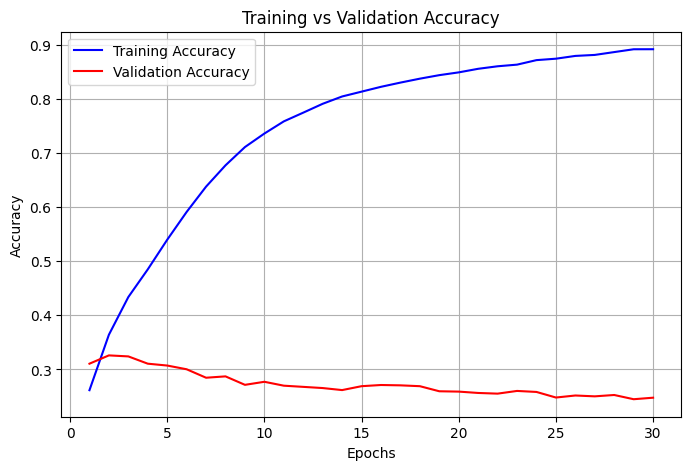

In [142]:
import matplotlib.pyplot as plt

# Extract accuracy values
acc = history_lstm.history['accuracy']
val_acc = history_lstm.history['val_accuracy']

# Extract loss values (optional, for a second plot)
loss = history_lstm.history['loss']
val_loss = history_lstm.history['val_loss']

epochs = range(1, len(acc) + 1)

# Plot Accuracy
plt.figure(figsize=(8, 5))
plt.plot(epochs, acc, 'b-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


In [143]:
#compile the model
model_lstm.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [144]:
#fit the model
history_lstm = model_lstm.fit(X_train, y_train,validation_split=0.1,epochs=15,batch_size=32)


Epoch 1/15
900/900 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - accuracy: 0.8882 - loss: 0.3778 - val_accuracy: 0.2544 - val_loss: 4.7724
Epoch 2/15
900/900 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.8958 - loss: 0.3596 - val_accuracy: 0.2434 - val_loss: 4.9575
Epoch 3/15
900/900 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.8945 - loss: 0.3524 - val_accuracy: 0.2463 - val_loss: 4.6666
Epoch 4/15
900/900 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - accuracy: 0.9040 - loss: 0.3332 - val_accuracy: 0.2419 - val_loss: 4.8180
Epoch 5/15
900/900 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.9035 - loss: 0.3276 - val_accuracy: 0.2466 - val_loss: 4.7848
Epoch 6/15
900/900 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9058 - loss: 0.3215 - val_accuracy: 0.2491 - val_loss: 4.9801
Epoch 7/15
900/900 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.9083 - loss: 0.3074 - val_accuracy: 0.2541 - val_loss: 5.0892
Epoch 8/15
900/900 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.9132 - loss: 0.3018 - val_acc

In [145]:
# Evaluate the model
loss_lstm, acc_lstm = model_lstm.evaluate(X_test, y_test)
print(f"\nLSTM Test Accuracy: {acc_lstm:.4f}")

250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.2416 - loss: 5.2164

LSTM Test Accuracy: 0.2394


BIDIRECTIONAL LSTM:

In [146]:
#Build the bidirectional LSTM model
model_bi_lstm = Sequential()
model_bi_lstm.add(Embedding(input_dim=30441, output_dim=128, input_length=max_len))
model_bi_lstm.add(Bidirectional(LSTM(64, return_sequences=True)))
model_bi_lstm.add(Dropout(0.5))
model_bi_lstm.add(Bidirectional(LSTM(32)))
model_bi_lstm.add(Dense(13, activation='softmax'))

In [147]:
#compile the model
model_bi_lstm.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [148]:
#fit the model
history_bi_lstm = model_bi_lstm.fit(X_train, y_train,validation_split=0.1,epochs=15,batch_size=32)


Epoch 1/15
900/900 ━━━━━━━━━━━━━━━━━━━━ 16s 14ms/step - accuracy: 0.2691 - loss: 2.0943 - val_accuracy: 0.3406 - val_loss: 1.9455
Epoch 2/15
900/900 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - accuracy: 0.4172 - loss: 1.7509 - val_accuracy: 0.3444 - val_loss: 1.9661
Epoch 3/15
900/900 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - accuracy: 0.5496 - loss: 1.4275 - val_accuracy: 0.3147 - val_loss: 2.1176
Epoch 4/15
900/900 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - accuracy: 0.6665 - loss: 1.0993 - val_accuracy: 0.3034 - val_loss: 2.3531
Epoch 5/15
900/900 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - accuracy: 0.7358 - loss: 0.8542 - val_accuracy: 0.2944 - val_loss: 2.6499
Epoch 6/15
900/900 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - accuracy: 0.7874 - loss: 0.6867 - val_accuracy: 0.2853 - val_loss: 2.9138
Epoch 7/15
900/900 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - accuracy: 0.8178 - loss: 0.5716 - val_accuracy: 0.2841 - val_loss: 3.2037
Epoch 8/15
900/900 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - accuracy: 0.8364 - loss: 0.5027 - 

In [149]:
# Evaluate the model
loss_bi_lstm, acc_bi_lstm = model_bi_lstm.evaluate(X_test, y_test)
print(f"\nLSTM Test Accuracy: {acc_bi_lstm:.4f}")

250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.2515 - loss: 4.7799

LSTM Test Accuracy: 0.2496


In [150]:
#compare accuracy
print(f"\nFinal Accuracy Comparison:")
print(f"RNN  → {acc_rnn:.4f}")
print(f"LSTM → {acc_lstm:.4f}")
print(f"BIDIRECTIONAL LSTM → {acc_bi_lstm:.4f}")


Final Accuracy Comparison:
RNN  → 0.2338
LSTM → 0.2394
BIDIRECTIONAL LSTM → 0.2496


In [151]:
import numpy as np
print(np.unique(y_train))
print(np.unique(y_test))


[ 0  1  2  3  4  5  6  7  8  9 10 11 12]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12]


**PREDICT SENTIMENT**

In [156]:
def predict_sentiment(tweet, tokenizer, model, label_encoder, max_len=50):
    # Clean the input tweet
    tweet_cleaned = preprocess_tweet(tweet)

    # Convert to sequence and pad
    sequence = tokenizer.texts_to_sequences([tweet_cleaned])
    padded = pad_sequences(sequence, maxlen=50)

    # Predict
    prediction = model.predict(padded)
    predicted_class = np.argmax(prediction, axis=1)[0]

    # Decode predicted class to label
    predicted_label = label_encoder.inverse_transform([predicted_class])[0]

    return predicted_label

In [165]:
#Access the tweet text for prediction(e.g:sadness)
row = tweet_emotions[tweet_emotions['sentiment'] == 'sadness'].iloc[5]
# Print original,preprocessed tweet,and user sentiment
print("Original Tweet:", row['content'])
print("Preprocessed Tweet:", row['preprocess_content'])
print("Sentiment Label:", row['sentiment'])

Original Tweet: Ugh! I have to beat this stupid song to get to the next  rude!
Preprocessed Tweet: ugh beat stupid song get next rude
Sentiment Label: sadness


In [166]:
#Test prediction
new_tweet = "ugh beat stupid song get next rude"
predicted = predict_sentiment(new_tweet, tokenizer,model_bi_lstm, Label)
print(f"\nTweet: \"{new_tweet}\"\nPredicted Sentiment: {predicted} 😞")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step

Tweet: "ugh beat stupid song get next rude"
Predicted Sentiment: sadness 😞
